In [26]:
import sympy as sp
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from CommonFunctions import *
%matplotlib inline

# Harmonic oscillators

## Linear harmonic oscillator

$$ \frac{d^2x}{dt^2} + \beta \frac{dx}{dt} + \omega x = F \cos{\Omega t} $$

With initial conditions:

$$x(0) = 1, x'(0) = 0$$

In [2]:
t, beta, omega, F, Omega = sp.symbols('t beta omega F Omega')
x = sp.Function('x')
diff_eq = sp.Eq(x(t).diff(t, 2) + beta*x(t).diff(t) + omega * x(t), F * sp.cos(Omega * t))
diff_eq

Eq(beta*Derivative(x(t), t) + omega*x(t) + Derivative(x(t), (t, 2)), F*cos(Omega*t))

In [3]:
beta_val, omega_val, F_val, Omega_val = sp.Rational(1, 4), 1, 2, 2
beta_val_float = 1/4
x_eq = diff_eq.subs([(beta, beta_val), (omega, omega_val), (F, F_val), (Omega, Omega_val)])
x_eq

Eq(x(t) + Derivative(x(t), t)/4 + Derivative(x(t), (t, 2)), 2*cos(2*t))

In [4]:
ics = {x(0): 5, x(t).diff(t).subs(t, 0): 0}
oscillator_sol = sp.dsolve(x_eq, x(t), ics=ics)
oscillator_sol

Eq(x(t), (145*sqrt(7)*sin(3*sqrt(7)*t/8)/777 + 209*cos(3*sqrt(7)*t/8)/37)*exp(-t/8) + 4*sin(2*t)/37 - 24*cos(2*t)/37)

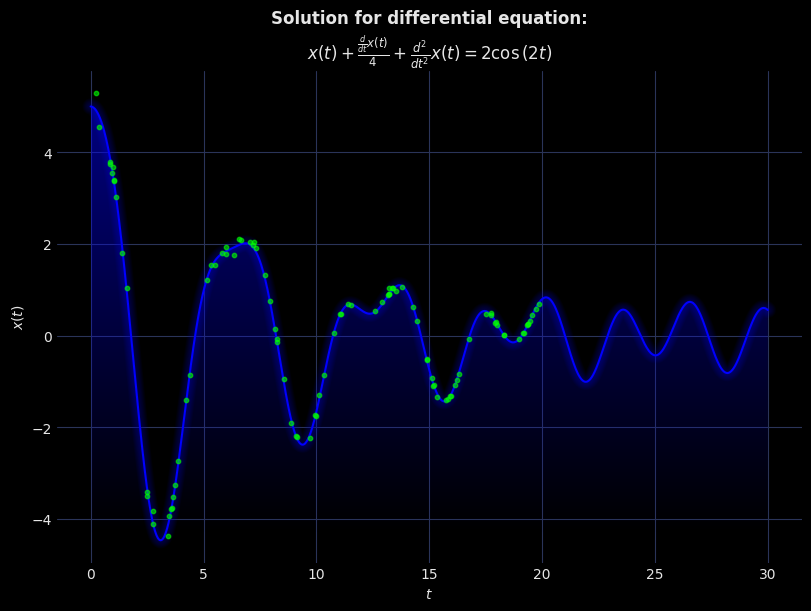

In [5]:
t_max = 30
t_values = np.linspace(0, t_max, 1001)
oscillator_function = sp.lambdify(t, oscillator_sol.rhs, 'numpy')

datapoints = {'t': np.random.uniform(0, 20, 100)}
datapoints['x'] = (x_true := oscillator_function(datapoints['t'])) + np.random.normal(0, np.abs(x_true) * 0.05)

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(t_values, oscillator_function(t_values), color='blue')
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', zorder=10, alpha=0.6, s=10)
    # axes.grid()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'Solution for differential equation:\n'
                   f'${sp.latex(x_eq)}$')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)
figure.savefig('images/image1.png')

# Creating the models

In [29]:
class ModularNeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 output_size: int, 
                 layer_sizes: tuple[int] = (), 
                 activation_function: nn.modules.activation = nn.Tanh()):
        super(ModularNeuralNetwork, self).__init__()
        if len(layer_sizes) == 0:
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=output_size),
                activation_function
            )
        elif len(layer_sizes) == 1:
            size = layer_sizes[0]
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=size),
                activation_function,
                nn.Linear(in_features=size, out_features=output_size),
                activation_function
            )
        else:
            layers = []
            for index, layer_size in enumerate(layer_sizes):
                if index == 0:
                    layer = nn.Linear(in_features=input_size, out_features=layer_size)
                else:
                    layer = nn.Linear(in_features=layer_sizes[index - 1], 
                                      out_features=layer_size)
                layers += [layer, activation_function]
            layers += [nn.Linear(in_features=layer_sizes[-1], 
                                 out_features=output_size)]
            self.layers = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

def plot_losses(figure, axes, loss_dict, title=None, **scatter_params):
    colors = ['red', 'cyan']
    legend = []
    for color, (loss_type, loss) in zip(colors, loss_dict.items()):
        axes.scatter(range(1, len(loss) + 1), loss / max(loss), 
                     label=loss_type, color=color, **scatter_params)
        legend.append(
            Line2D([0], [0], marker='o', markerfacecolor=color, 
                   markersize=10, label=loss_type, alpha=1))
    axes.set(xlabel='epoch', ylabel='loss', title=title, yscale='log')
    axes.legend(handles=legend)
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
epochs = 15000
learning_rate = 0.005
hidden_layers = 200, 200, 200
NN = ModularNeuralNetwork(input_size=1,
                          output_size=1,
                          layer_sizes=hidden_layers,
                          activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_nn = np.zeros(epochs)
NN.train()
for epoch in range(epochs):
    y_pred = NN(X)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_nn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 3.915327787399292
Epoch 1000, Loss: 0.012650687247514725
Epoch 2000, Loss: 0.01397678628563881
Epoch 3000, Loss: 0.006583857350051403
Epoch 4000, Loss: 0.005127297714352608
Epoch 5000, Loss: 0.010961626656353474
Epoch 6000, Loss: 0.013849731534719467
Epoch 7000, Loss: 0.001931260689161718
Epoch 8000, Loss: 0.010238916613161564
Epoch 9000, Loss: 0.0014945367584004998
Epoch 10000, Loss: 0.0010885236551985145
Epoch 11000, Loss: 0.0010928440606221557
Epoch 12000, Loss: 0.00196241051889956
Epoch 13000, Loss: 0.002706712344661355
Epoch 14000, Loss: 0.0014846335398033261


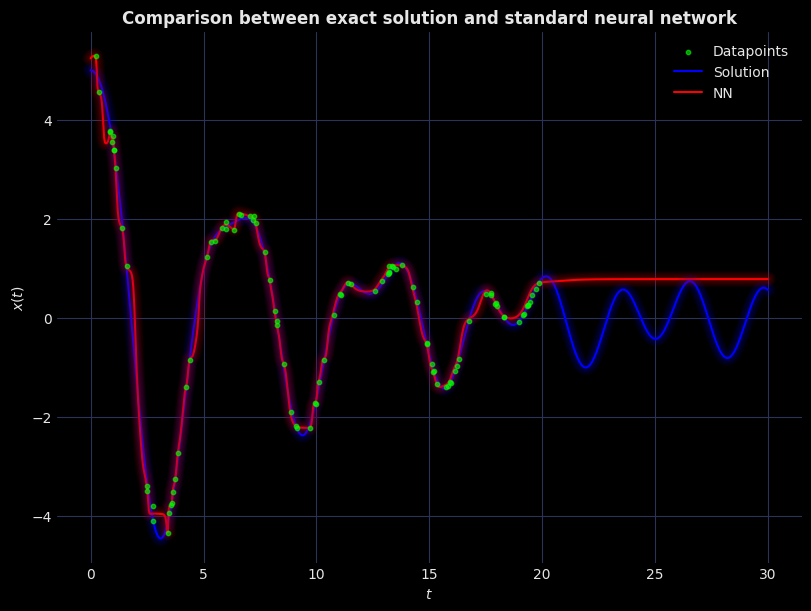

In [8]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], 
                 color='lime', label='Datapoints', zorder=10, alpha=0.6, s=10)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='red', label='NN')
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title='Comparison between exact solution and standard neural network')
    enhance_plot(figure, axes, glow=True)
figure.savefig('images/image2.png')

In [9]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True).to(device)
epochs = 25000
learning_rate = 0.0005
hidden_layers = 200, 200, 200
physics_lambda = 10
PINN = ModularNeuralNetwork(input_size=1,
                            output_size=1,
                            layer_sizes=hidden_layers,
                            activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(PINN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_pinn = np.zeros(epochs)
PINN.train()
for epoch in range(epochs):
    y_pred = PINN(X)
    loss1 = criterion(y_pred, y)
    y_physics = PINN(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = ((omega_val) * y_physics) + (dx * beta_val_float) + dx2 - (F_val * torch.cos(Omega_val * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_pinn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 3.9895009994506836, Physics Loss: 20.480632781982422
Epoch 1000, MSE Loss: 0.9164498448371887, Physics Loss: 16.08646583557129
Epoch 2000, MSE Loss: 0.9300663471221924, Physics Loss: 15.995868682861328
Epoch 3000, MSE Loss: 0.8813387155532837, Physics Loss: 14.60401439666748
Epoch 4000, MSE Loss: 0.4069187343120575, Physics Loss: 11.057095527648926
Epoch 5000, MSE Loss: 0.031164625659585, Physics Loss: 8.121787071228027
Epoch 6000, MSE Loss: 0.07646340876817703, Physics Loss: 6.868748664855957
Epoch 7000, MSE Loss: 0.013927056454122066, Physics Loss: 3.7494568824768066
Epoch 8000, MSE Loss: 0.011247072368860245, Physics Loss: 1.4036667346954346
Epoch 9000, MSE Loss: 0.009152858518064022, Physics Loss: 0.28330108523368835
Epoch 10000, MSE Loss: 0.007155763451009989, Physics Loss: 0.016254344955086708
Epoch 11000, MSE Loss: 0.00802384689450264, Physics Loss: 0.019785435870289803
Epoch 12000, MSE Loss: 0.007416083011776209, Physics Loss: 0.009941903874278069
Epoch 13000

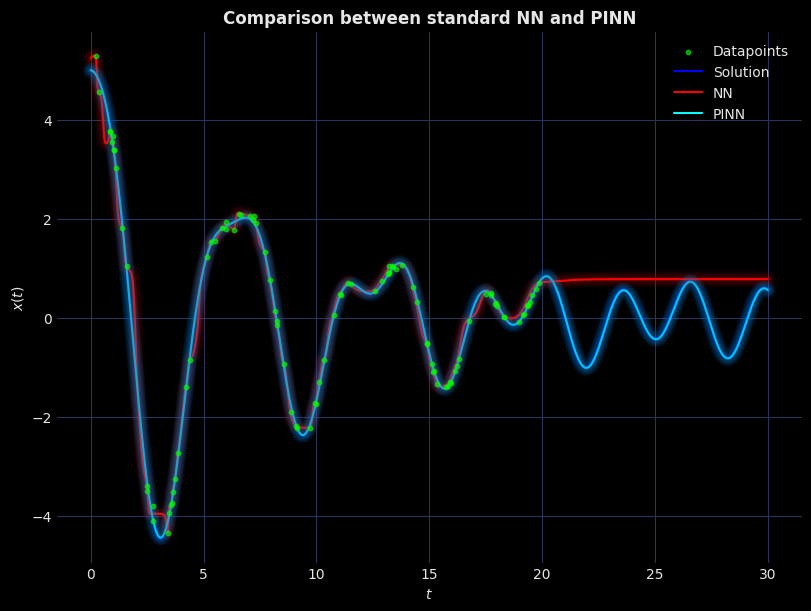

In [10]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], 
                 color='lime', label='Datapoints', zorder=10, alpha=0.6, s=10)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='red', label='NN')
    axes.plot(t_val_tensor, PINN(t_val_tensor.cuda()).cpu().detach(), color='cyan', label='PINN')
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'Comparison between standard NN and PINN')
    enhance_plot(figure, axes, glow=True)
figure.savefig('images/image3.png')

# Approximating the damping factor $\beta$

In [11]:
class BetaApproximator(ModularNeuralNetwork):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 layer_sizes:tuple[int] = (),
                 activation_function: nn.Module = nn.Tanh()):
        super(BetaApproximator, self).__init__(
            input_size, output_size,
            layer_sizes=layer_sizes,
            activation_function=activation_function
        )
        self.beta = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)

In [12]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True).to(device)
epochs = 75000
learning_rate = 0.0005
hidden_layers = 200, 200, 200
physics_lambda = 10
Approximator = BetaApproximator(
    input_size=1,
    output_size=1,
    layer_sizes=hidden_layers,
    activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(Approximator.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_app = np.zeros(epochs)
Approximator.train()
for epoch in range(epochs):
    y_pred = Approximator(X)
    loss1 = criterion(y_pred, y)
    y_physics = Approximator(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = (y_physics * omega_val) + (dx * Approximator.beta) + dx2 - (F_val * torch.cos(Omega_val * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_app[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 3.8798601627349854, Physics Loss: 20.290496826171875
Epoch 1000, MSE Loss: 0.9138949513435364, Physics Loss: 15.987296104431152
Epoch 2000, MSE Loss: 0.8983692526817322, Physics Loss: 15.924114227294922
Epoch 3000, MSE Loss: 0.9207099676132202, Physics Loss: 15.890170097351074
Epoch 4000, MSE Loss: 0.29904940724372864, Physics Loss: 11.523709297180176
Epoch 5000, MSE Loss: 0.04991127923130989, Physics Loss: 7.9496026039123535
Epoch 6000, MSE Loss: 0.08355836570262909, Physics Loss: 6.044785499572754
Epoch 7000, MSE Loss: 0.059165164828300476, Physics Loss: 3.824887752532959
Epoch 8000, MSE Loss: 0.02789224125444889, Physics Loss: 2.8025050163269043
Epoch 9000, MSE Loss: 0.034127116203308105, Physics Loss: 1.365753173828125
Epoch 10000, MSE Loss: 0.03306809440255165, Physics Loss: 0.4302123188972473
Epoch 11000, MSE Loss: 0.0071781775914132595, Physics Loss: 0.00924797635525465
Epoch 12000, MSE Loss: 0.007328514475375414, Physics Loss: 0.0036922218278050423
Epoch 1300

In [13]:
print(f'Comparison between real and approximated values:\n'
      f'beta: real = {beta_val:.3f}, approximated: {Approximator.beta.item():.3f}\n')

Comparison between real and approximated values:
beta: real = 0.250, approximated: 0.250


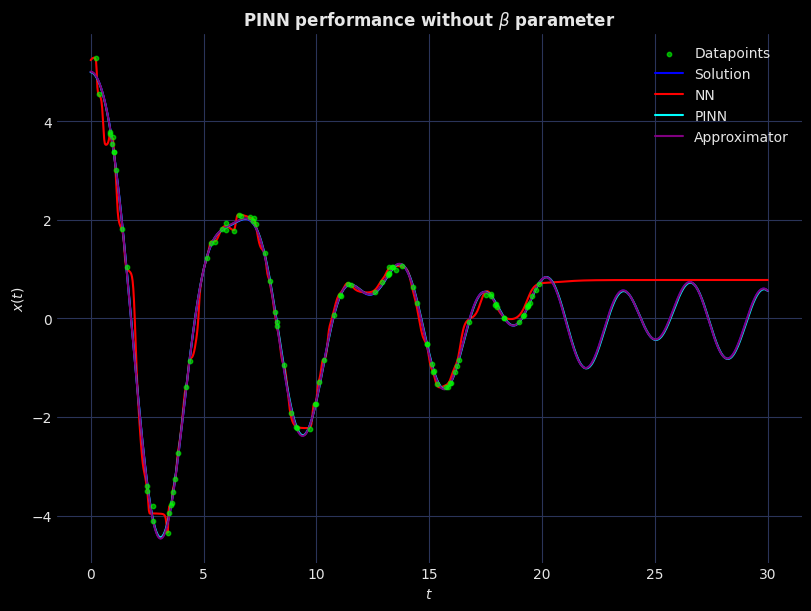

In [14]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], 
                 color='lime', label='Datapoints', zorder=10, alpha=0.6, s=10)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='red', label='NN')
    axes.plot(t_val_tensor, PINN(t_val_tensor.cuda()).cpu().detach(), color='cyan', label='PINN')
    axes.plot(t_val_tensor, Approximator(t_val_tensor.cuda()).cpu().detach(), color='purple', label='Approximator')
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'PINN performance without $\\beta$ parameter')
    enhance_plot(figure, axes)
figure.savefig('images/image4.png')

We can see that approximator struggles for region outside of the sampled data, but it still performs way better than normal neural network. Let's add more samples from wider range. Let's add more noise.

# Approximating all parameters:
* damping factor $\beta$
* oscillator frequency $\omega$
* driving force $F$
* driving force frequency $\Omega$

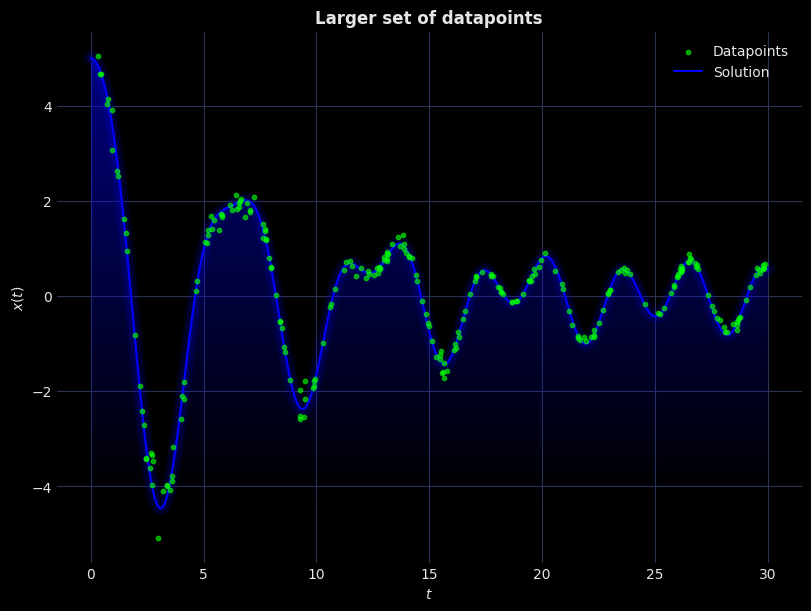

In [15]:
oscillator_function = sp.lambdify(t, oscillator_sol.rhs, 'numpy')

datapoints = {'t': np.random.uniform(0, t_max, 250)}
datapoints['x'] = (x_true := oscillator_function(datapoints['t'])) + np.random.normal(0, np.abs(x_true) * 0.1)

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], 
                 color='lime', zorder=10, alpha=0.6, label='Datapoints', s=10)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    # axes.grid()
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$', title='Larger set of datapoints')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)
figure.savefig('images/image5.png')

In [16]:
class OscillatorApproximator(ModularNeuralNetwork):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 layer_sizes:tuple[int] = (),
                 activation_function: nn.Module = nn.Tanh()):
        super(OscillatorApproximator, self).__init__(
            input_size, output_size,
            layer_sizes=layer_sizes,
            activation_function=activation_function
        )
        
        initial_value = 2
        self.beta = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
        self.omega = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
        self.F = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
        self.Omega = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
    
    def get_estimated_params(self):
        return (param.item() for param in [self.beta, self.omega, self.F, self.Omega])

In [17]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True).to(device)
epochs = 150000
learning_rate = 0.0001
hidden_layers = 1000, 1000
physics_lambda = 10
mse_lambda = 1
Approximator2 = OscillatorApproximator(
    input_size=1,
    output_size=1,
    layer_sizes=hidden_layers,
    activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(Approximator2.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
mse_loss_app = np.zeros(epochs)
physics_loss_app = np.zeros(epochs)
Approximator2.train()
for epoch in range(epochs):
    y_pred = Approximator2(X)
    loss1 = mse_lambda * criterion(y_pred, y)
    y_physics = Approximator2(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = (y_physics * Approximator2.omega) + (dx * Approximator2.beta) + dx2 - (Approximator2.F * torch.cos(Approximator2.Omega * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    mse_loss_app[epoch] = loss1.item()
    physics_loss_app[epoch] = loss2.item()
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 2.5274152755737305, Physics Loss: 24.11492156982422
Epoch 2000, MSE Loss: 1.618980050086975, Physics Loss: 13.808545112609863
Epoch 4000, MSE Loss: 1.6015361547470093, Physics Loss: 11.666149139404297
Epoch 6000, MSE Loss: 1.4599241018295288, Physics Loss: 8.289103507995605
Epoch 8000, MSE Loss: 1.348138451576233, Physics Loss: 6.197902679443359
Epoch 10000, MSE Loss: 1.230743408203125, Physics Loss: 4.377595901489258
Epoch 12000, MSE Loss: 1.0724141597747803, Physics Loss: 3.0126237869262695
Epoch 14000, MSE Loss: 0.8882142901420593, Physics Loss: 1.8789137601852417
Epoch 16000, MSE Loss: 0.6026619076728821, Physics Loss: 0.9178500175476074
Epoch 18000, MSE Loss: 0.41216763854026794, Physics Loss: 0.4613971710205078
Epoch 20000, MSE Loss: 0.33540353178977966, Physics Loss: 0.19667746126651764
Epoch 22000, MSE Loss: 0.32263684272766113, Physics Loss: 0.06873780488967896
Epoch 24000, MSE Loss: 0.30919790267944336, Physics Loss: 0.03808268904685974
Epoch 26000, MSE Los

In [18]:
print(f'Comparison between real and approximated values:\n'
      f'beta: real = {beta_val:.3f}, approximated: {Approximator2.beta.item():.3f}\n'
      f'omega: real = {omega_val:.3f}, approximated: {Approximator2.omega.item():.3f}\n'
      f'F: real = {F_val:.3f}, approximated: {Approximator2.F.item():.3f}\n'
      f'Omega: real = {Omega_val:.3f}, approximated: {Approximator2.Omega.item():.3f}')

Comparison between real and approximated values:
beta: real = 0.250, approximated: 0.249
omega: real = 1.000, approximated: 0.998
F: real = 2.000, approximated: 1.965
Omega: real = 2.000, approximated: 2.000


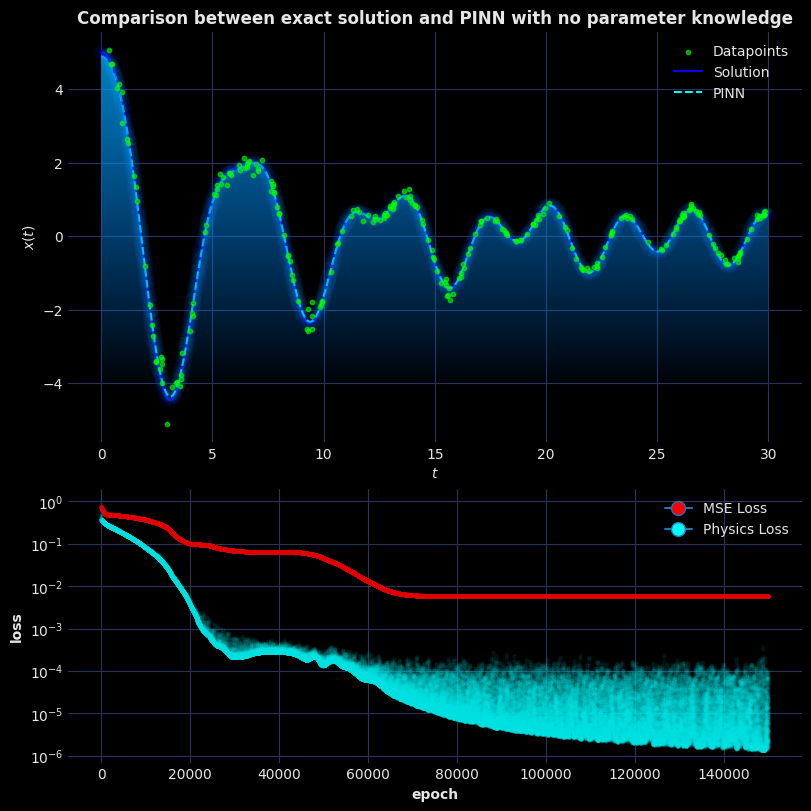

In [30]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 8), height_ratios=[3, 2])
    axes[0].scatter(datapoints['t'], datapoints['x'], 
                    color='lime', zorder=10, alpha=0.6, s=10, label='Datapoints')
    axes[0].plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    axes[0].plot(t_val_tensor, Approximator2(t_val_tensor.cuda()).cpu().detach(), 
                 color='cyan', linestyle='--', label='PINN')
    # axes.grid()
    axes[0].legend()
    axes[0].set(xlabel='$t$', ylabel='$x(t)$',
                title=f'Comparison between exact solution and PINN with no parameter knowledge')
    enhance_plot(figure, axes[0], glow=True, alpha_gradient=0.5)
    plot_losses(figure, axes[1], {'MSE Loss': mse_loss_app, 'Physics Loss': physics_loss_app}, 
                title=None, s=6, alpha=0.03)
figure.savefig('images/image6.png')

Long range prediction using found parameters

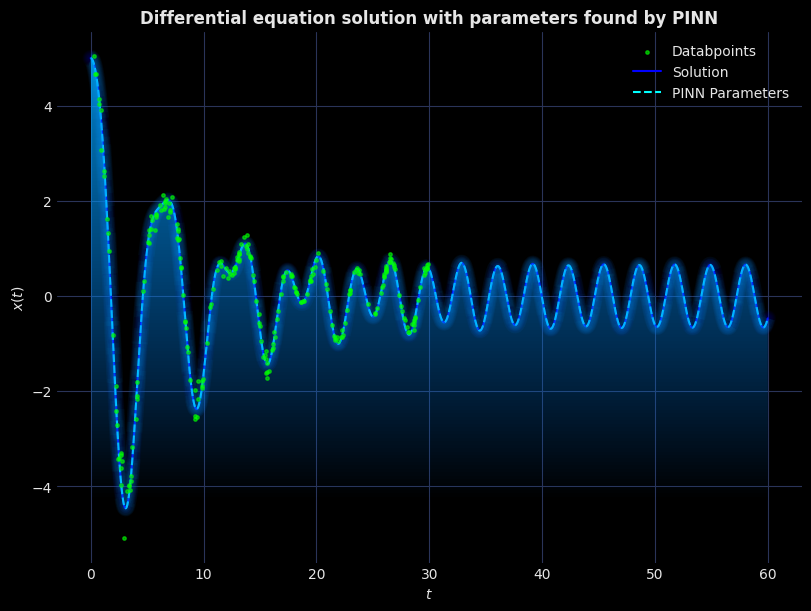

In [21]:
x_eq_approx = diff_eq.subs([(var, val) for var, val in 
                            zip((beta, omega, F, Omega), 
                                Approximator2.get_estimated_params())])
approximator_func = sp.lambdify(t, sp.dsolve(x_eq, x(t), ics=ics).rhs, 'numpy')

t_values_long_range = np.linspace(0, 60, 5000)
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], 
                 color='lime', zorder=10, alpha=0.6, s=6, label='Databpoints')
    axes.plot(t_values_long_range, oscillator_function(t_values_long_range), 
              color='blue', label='Solution')
    axes.plot(t_values_long_range, approximator_func(t_values_long_range), 
              color='cyan', linestyle='--', label='PINN Parameters')
    # axes.grid()
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'Differential equation solution with parameters found by PINN')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)
figure.savefig('images/image7.png')